# GAN 구현 --> 피드포워드 신경망 & DCGAN(합성곱신경망을 활용한 GAN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Activation, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100 # 생성자의 입력으로 사용될 잡음 벡터의 크기

In [3]:
# 1. 피드포워드 신경망을 활용한 GAN

# Build Generator

def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수
  model.add(Dense(28*28*1, activation='tanh'))  # tanh 활성화 함수를 활용한 출력층
  model.add(Reshape(img_shape))  # 생성자의 출력값을 (img_rows, img_cols, channels)로 변경

  return model


# Build Discriminator
# (img_rows, img_cols, channels) 크기의 입력을 받아 가짜와 비교해 얼마나 진짜인지를 나타내는 확률 출력

def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))   # 우선, 입력으로 들어온 이미지를 바로 펼침
  model.add(Dense(128)) # FC layer
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))  # 출력층 뉴런개수 1 + sigmoid function --> 판별자가 입력을 진짜로 생각하는 정도를 0~1 사이 확률로 도출
  
  return model


# Build GAN

def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  return model




discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False    # 생성자 모델 훈련 시 판별자 파라미터 Freeze

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [4]:
# GAN Train
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  (X_train, _), (_, _) = mnist.load_data()

  # X_train의 [0, 255]사이의 흑백 픽셀 값을 [-1, 1]사이로 스케일 조정
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)   

  real = np.ones((batch_size, 1))  # 진짜 이미지 레이블 --> 모두 1
  fake = np.zeros((batch_size, 1))  # 가짜 이미지 레이블 --> 모두 0

  for iteration in range(iterations):

    # 진짜 이미지에서 랜덤 배치 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 생성자 --> 가짜 배치 이미지 생성
    z = np.random.normal(0, 1, (batch_size, 100))  # 평균:0, 표준편차:1 인 준정규분포에서 샘플링하여 z벡터 생성
    gen_imgs = generator.predict(z)

    # 판별자 훈련
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 생성자 훈련
    z = np.random.normal(0, 1, (batch_size,100))  # 가짜 이미지 배치 생성
    gen_imgs = generator.predict(z)
    g_loss = gan.train_on_batch(z, real)

    if (iteration+1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration+1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

In [5]:
# sample_images 출력

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))  # 랜담한 잡음 샘플링

  gen_imgs = generator.predict(z) # 랜덤한 잡음 z에서 이미지 생성
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

1000 [D loss: 0.049213, acc.: 99.22%] [G loss: 4.062360]
2000 [D loss: 0.110865, acc.: 97.27%] [G loss: 4.943581]
3000 [D loss: 0.056373, acc.: 98.83%] [G loss: 5.240033]
4000 [D loss: 0.125396, acc.: 94.53%] [G loss: 4.681098]
5000 [D loss: 0.323563, acc.: 87.50%] [G loss: 3.492941]
6000 [D loss: 0.128193, acc.: 95.31%] [G loss: 4.462819]
7000 [D loss: 0.421462, acc.: 84.77%] [G loss: 3.682365]
8000 [D loss: 0.275022, acc.: 88.67%] [G loss: 4.077869]
9000 [D loss: 0.311799, acc.: 89.84%] [G loss: 3.328396]
10000 [D loss: 0.241981, acc.: 90.23%] [G loss: 3.813868]
11000 [D loss: 0.239553, acc.: 88.67%] [G loss: 4.191863]
12000 [D loss: 0.412845, acc.: 79.69%] [G loss: 2.497483]
13000 [D loss: 0.266110, acc.: 89.06%] [G loss: 2.810597]
14000 [D loss: 0.442449, acc.: 84.77%] [G loss: 3.382136]
15000 [D loss: 0.228065, acc.: 90.62%] [G loss: 2.841094]
16000 [D loss: 0.334138, acc.: 85.16%] [G loss: 2.768955]
17000 [D loss: 0.363001, acc.: 82.42%] [G loss: 2.538361]
18000 [D loss: 0.382868

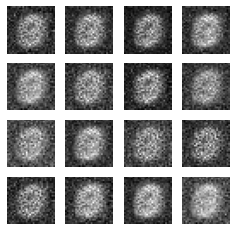

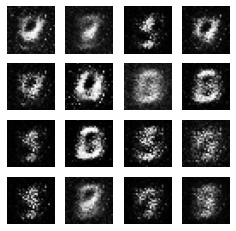

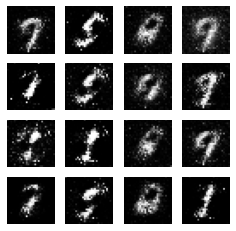

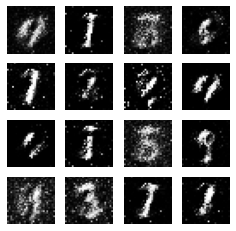

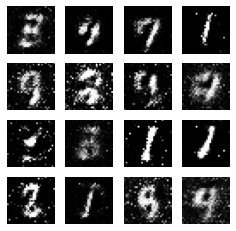

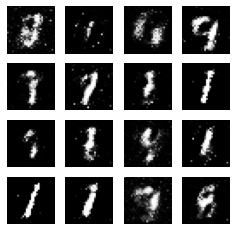

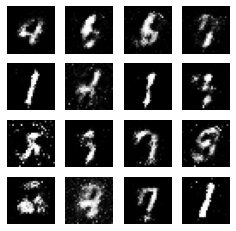

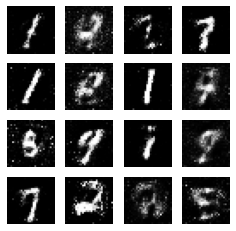

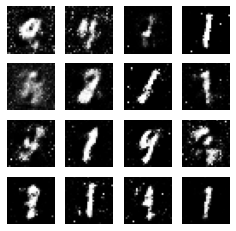

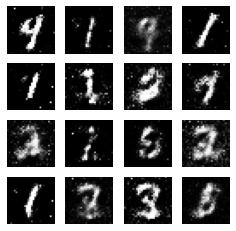

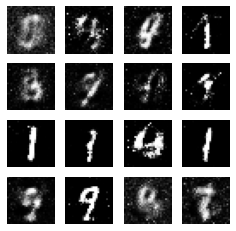

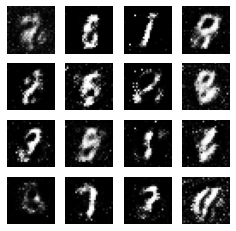

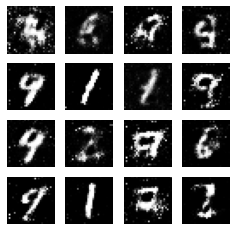

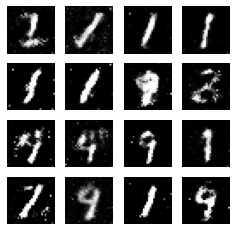

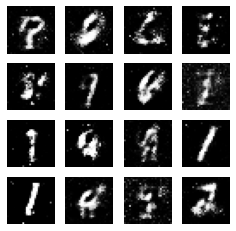

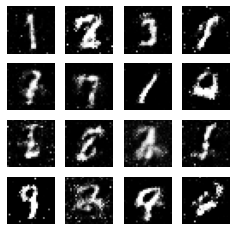

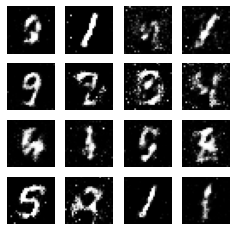

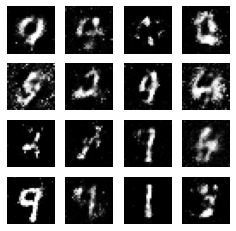

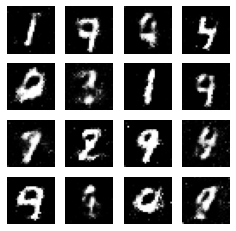

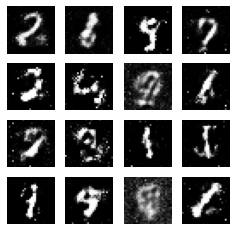

In [6]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [17]:
# 2. CNN을 활용한 GAN --> DCGAN
# 같은 mnist 데이터를 쓰므로 img_rows, img_cols, channels값은 같음 + 생성자 입력으로 쓰인 noise의 벡터 크기또한 100으로 같음

# Build DCGAN Generator : CNN의 구조를 그대로 뒤집어 깊이는 줄이고, 너비&높이는 늘리는 Conv2DTranspose 모듈 사용

def build_dcgan_generator(z_dim):

  model = Sequential()
  model.add(Dense(256*7*7, input_dim=z_dim))
  model.add(Reshape((7,7,256)))  # 입력을 7*7*256 크기의 텐서로 변환

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))  # 14*14*128
  # BN + LeakyReLU - BN은 보통 활성화 함수 앞에다 붙임
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))  # 14*14*64
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))  # 28*28*1
  model.add(Activation('tanh'))

  return model


def build_dcgan_discriminator(img_shape):

  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))   # 28*28*1 크기의 입력을 14*14*32 크기의 텐서로 변환
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))  # 7*7*64
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same')) # 3*3*128
  model.add(LeakyReLU(alpha=0.01))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))  # 이미지가 진짜인지 가짜인지 확률을 sigmoid function으로 알림

  return model


def build_dcgan(dcgan_generator, dcgan_discriminator):

  model = Sequential()
  model.add(dcgan_generator)
  model.add(dcgan_discriminator)
  return model

dcgan_discriminator = build_dcgan_discriminator(img_shape)
dcgan_discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

dcgan_generator = build_dcgan_generator(z_dim)
dcgan_discriminator.trainable = False

dcgan = build_dcgan(dcgan_generator, dcgan_discriminator)
dcgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [18]:
# DCGAN Training

losses = []
accuracies = []
iteration_checkpoints = []

def dcgan_train(iterations, batch_size, sample_interval):

  (X_train, _), (_, _) = mnist.load_data()

  # X_train의 [0, 255]사이의 흑백 픽셀 값을 [-1, 1]사이로 스케일 조정
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)   

  real = np.ones((batch_size, 1))  # 진짜 이미지 레이블 --> 모두 1
  fake = np.zeros((batch_size, 1))  # 가짜 이미지 레이블 --> 모두 0

  for iteration in range(iterations):

    # 진짜 이미지에서 랜덤 배치 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 생성자 --> 가짜 배치 이미지 생성
    z = np.random.normal(0, 1, (batch_size, 100))  # 평균:0, 표준편차:1 인 준정규분포에서 샘플링하여 z벡터 생성
    gen_imgs = dcgan_generator.predict(z)

    # 판별자 훈련
    d_loss_real = dcgan_discriminator.train_on_batch(imgs, real)
    d_loss_fake = dcgan_discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 생성자 훈련
    z = np.random.normal(0, 1, (batch_size,100))  # 가짜 이미지 배치 생성
    gen_imgs = dcgan_generator.predict(z)
    g_loss = dcgan.train_on_batch(z, real)

    if (iteration+1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration+1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(dcgan_generator)



def sample_images(dcgan_generator, image_grid_rows=4, image_grid_columns=4):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))  # 랜담한 잡음 샘플링

  gen_imgs = dcgan_generator.predict(z) # 랜덤한 잡음 z에서 이미지 생성
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

1000 [D loss: 0.520818, acc.: 74.22%] [G loss: 1.660458]
2000 [D loss: 0.493775, acc.: 78.91%] [G loss: 1.148697]
3000 [D loss: 0.409348, acc.: 82.42%] [G loss: 1.807670]
4000 [D loss: 0.475060, acc.: 77.73%] [G loss: 1.697556]
5000 [D loss: 0.419923, acc.: 80.86%] [G loss: 2.062889]
6000 [D loss: 0.512521, acc.: 75.00%] [G loss: 1.896733]
7000 [D loss: 0.473631, acc.: 76.56%] [G loss: 1.799155]
8000 [D loss: 0.413695, acc.: 82.03%] [G loss: 1.681684]
9000 [D loss: 0.427306, acc.: 79.30%] [G loss: 1.630010]
10000 [D loss: 0.401005, acc.: 79.69%] [G loss: 1.975834]
11000 [D loss: 0.472254, acc.: 78.91%] [G loss: 1.730154]
12000 [D loss: 0.433428, acc.: 81.25%] [G loss: 1.751239]
13000 [D loss: 0.403209, acc.: 80.08%] [G loss: 2.198593]
14000 [D loss: 0.512364, acc.: 73.83%] [G loss: 1.697083]
15000 [D loss: 0.479085, acc.: 80.08%] [G loss: 1.952190]
16000 [D loss: 0.391024, acc.: 82.03%] [G loss: 1.750237]
17000 [D loss: 0.375134, acc.: 84.38%] [G loss: 2.176262]
18000 [D loss: 0.381514

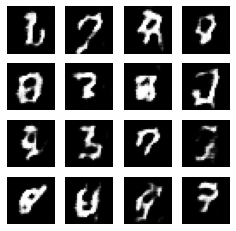

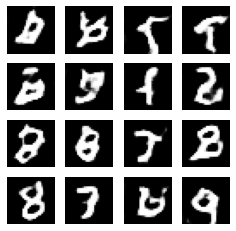

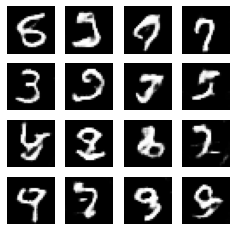

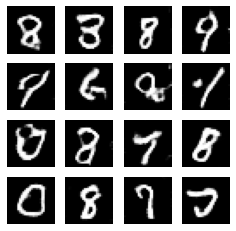

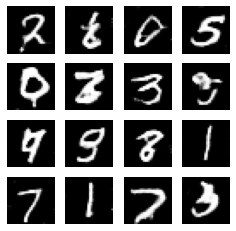

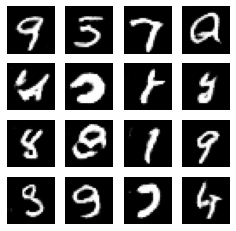

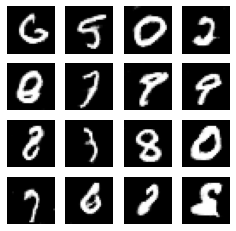

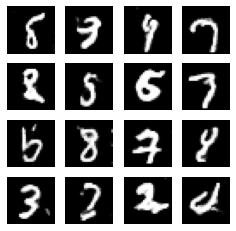

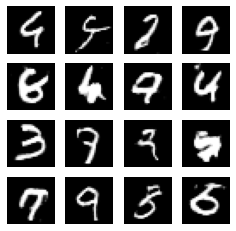

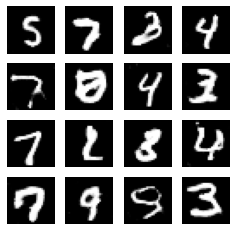

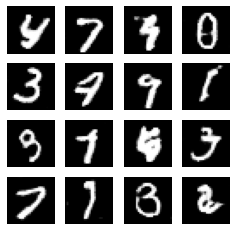

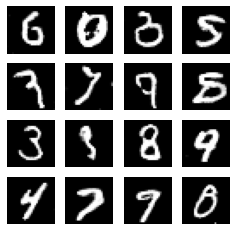

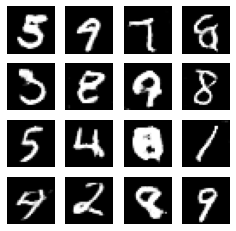

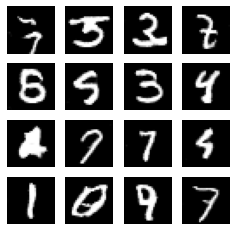

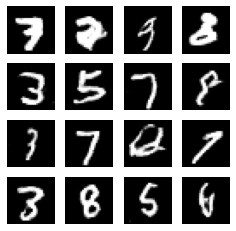

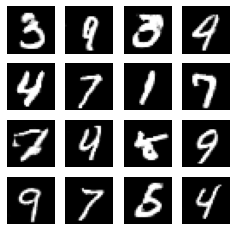

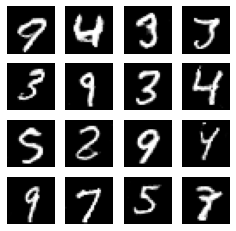

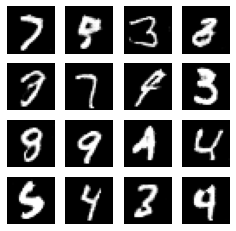

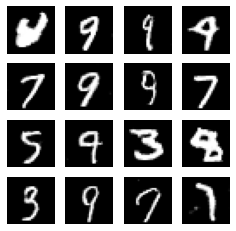

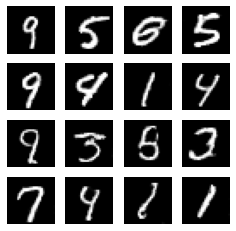

In [19]:
iterations = 20000
batch_size = 128
sample_interval = 1000

dcgan_train(iterations, batch_size, sample_interval)

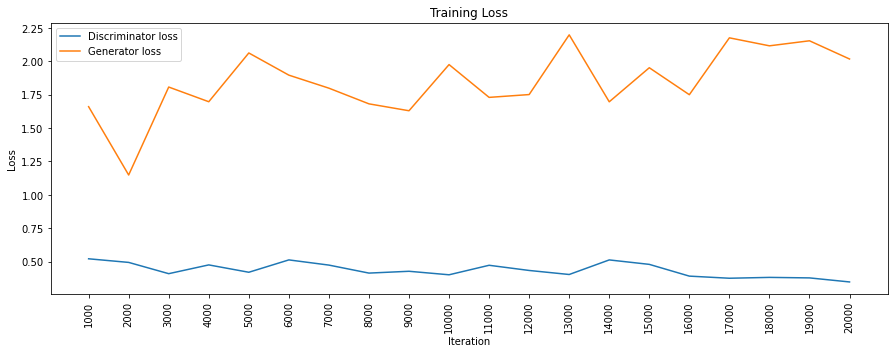

In [20]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

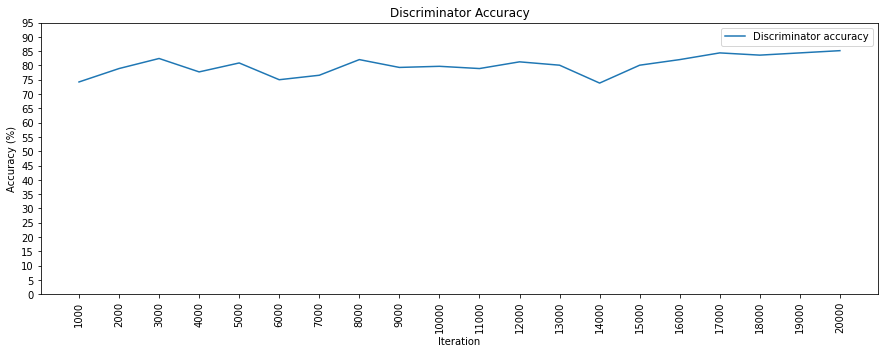

In [21]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()